# PSB injection bump in Xsuite

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

## Get MAD-X model

In [3]:
# Load mad thick model and apply element shifts
mad = Madx()
mad.input('''
    call, file = 'psb.seq';
    call, file = 'psb_fb_lhc.str';

    beam, particle=PROTON, pc=0.5708301551893517;
    use, sequence=psb1;
''')

# Add shifts on injection bumpers
mad.input('''
    select,flag=error,pattern=bi1.bsw1l1.1*;
    ealign, dx=-0.0057;

    select,flag=error,clear;
    select,flag=error,pattern=bi1.bsw1l1.2*;
    select,flag=error,pattern=bi1.bsw1l1.3*;
    select,flag=error,pattern=bi1.bsw1l1.4*;
    ealign, dx=-0.0442;
''')

mad.twiss() # To check that the model is fine



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.06.27 09:44:23      +
  ++++++++++++++++++++++++++++++++++++++++++++




  /************************************************************************************

  *

  * PS Booster version  (draft) LS2 in MAD X SEQUENCE format

  * Generated the 28-AUG-2020 16:25:27 from Layout

  *

  ************************************************************************************/







/************************************************************************************/

/*                       TYPES DEFINITION                                           */

/************************************************************************************/



//---------------------- COLLIMATOR     ---------------------------------------------

BR_SPSCRAP     : COLLIMATOR  , L := 0;         ! PSB

<Table 'twiss': {name, keyword, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, k11l, k11sl, k12l, k12sl, k13l, k13sl, k14l, k14sl, k15l, k15sl, k16l, k16sl, k17l, k17sl, k18l, k18sl, k19l, k19sl, k20l, k20sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, v_pos, bbcharge, xma, yma, sigx, sigy, lrad, parent, comments, re11, re12, re13, re14, re15, re16, re21, re22, re23, re24, re25, re26, re31, re32, re33, re34, re35, re36, re41, re42, re43, re44, re45, re46, re51, re52, re53, re54, re55, re56, re61, re62, re63, re64, re65, re66, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, alfa

## Build Xsuite line from MAD-X model

In [4]:
# Build line (thick elements)
line = xt.Line.from_madx_sequence(mad.sequence.psb1,
                                  allow_thick=True,
                                  enable_align_errors=True,
                                  deferred_expressions=True)

# Associate reference paricle to the line
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, gamma0=mad.sequence.psb1.beam.gamma)

# Switch to exact model for bends (PTC-like, approppriate for small rings)
line.configure_bend_method('full')

# Build tracker (by default single-core CPU)
line.build_tracker()

Converting sequence "psb1": 95%     
Found suitable prebuilt kernel `default_only_xtrack`.


### Twiss defaults
By default the Xsuite twiss is 6d (gives error if RF is not present).
We can set different defaults for our line, for example switch to 4d twiss:

In [5]:
line.twiss_default['method'] = '4d'

###  Save reload
At any moment the line can be saved to a json file and reloaded

In [80]:
# Save
line.to_json('psb_00_from_mad.json')

In [7]:
# Reload
line = xt.Line.from_json('psb_00_from_mad.json')
line.build_tracker()

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


## Working with the line (basics)

### Twiss

It is probably the most used method in Xsuite, it allows analyzing and diagnosing issues with the line model

In [8]:
tw = line.twiss()

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


Access scalar quantities (tunes, chromaticities, momentum compaction, rev period). For example: 

In [28]:
tw.qx, tw.qy, tw.dqy, tw.c_minus, tw.T_rev0

(4.3999999999169885,
 4.450000000576649,
 -7.149781341846406,
 0.0,
 1.0080991028513366e-06)

Plot beta functions, orbit, dispersion. 
We can see the shifts around the injection bumpers (work ongoing to hide this in the twiss results)

<IPython.core.display.Javascript object>


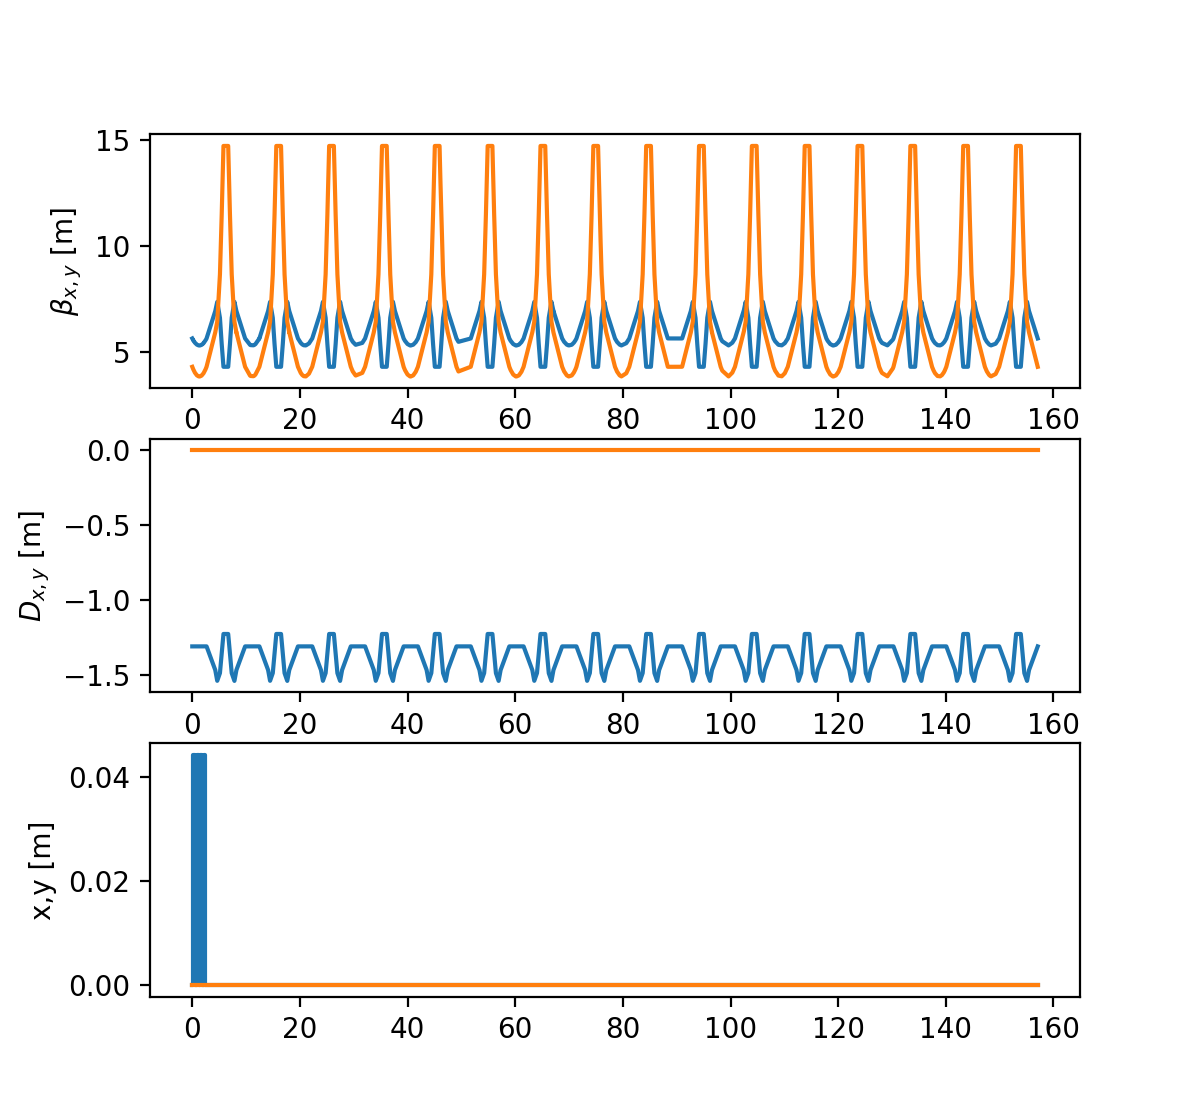

Text(0, 0.5, 'x,y [m]')

In [27]:
fig = plt.figure(1, figsize=(6, 4*1.4))
sp1 = plt.subplot(3,1,1)
sp2 = plt.subplot(3,1,2, sharex=sp1)
sp3 = plt.subplot(3,1,3, sharex=sp1)

sp1.plot(tw.s, tw.betx)
sp1.plot(tw.s, tw.bety)
sp1.set_ylabel(r'$\beta_{x,y}$ [m]')
sp2.plot(tw.s, tw.dx)
sp2.plot(tw.s, tw.dy)
sp2.set_ylabel(r'$D_{x,y}$ [m]')
sp3.plot(tw.s, tw.x)
sp3.plot(tw.s, tw.dy)
sp3.set_ylabel(r'x,y [m]')

### Working with twiss tables and inspecting line elements

Twiss table support several indexing modes. Here some examples:

In [42]:
# Select rows and colums (rows selected by index)
tw.rows[20:25].cols['s', 'betx', 'bety']

TwissTable: 5 rows, 4 cols
name                           s    betx    bety
bi1.bsw1l1.3_offset_entry 1.3975 5.30053 3.84019
bi1.bsw1l1.3_den          1.3975 5.30053 3.84019
bi1.bsw1l1.3              1.3975 5.30053 3.84019
bi1.bsw1l1.3_dex          1.7225 5.32891 3.87992
bi1.bsw1l1.3_offset_exit  1.7225 5.32891 3.87992

In [43]:
# Select rows and colums (rows selected by name)
tw.rows['br.spscrap11':'br1.bpm1l3'].cols['s', 'betx', 'bety']

TwissTable: 7 rows, 4 cols
name                            s    betx    bety
br.spscrap11               4.2717 6.92258   5.922
drift_9                    4.2717 6.92258   5.922
br1.vvs1l2                4.51482 7.20282 6.24668
drift_10                  4.51482 7.20282 6.24668
br.qfo11                  4.63801 7.35333 6.42193
drift_11                  5.14158 6.60335 8.65233
br1.bpm1l3                 5.4678   5.371 11.4618

In [53]:
# Select rows and colums (rows selected by `s` range)
tw.rows[150:153:'s'].cols['s', 'betx', 'bety']

TwissTable: 11 rows, 4 cols
name                            s    betx    bety
br.bhz161_dex             151.534 6.92258   5.922
drift_190                 151.534 6.92258   5.922
br.stscrap161             151.534 6.92258   5.922
drift_191                 151.534 6.92258   5.922
br.qfo161                 151.901 7.35333 6.42193
drift_192                 152.404 6.60335 8.65233
br1.bpm16l3                152.73 5.37085 11.4622
br1.onoh0.16l3             152.73 5.37085 11.4622
br1.qno16l3                152.73 5.37085 11.4622
br1.xnoh0.16l3             152.73 5.37085 11.4622
drift_193                  152.73 5.37085 11.4622

In [62]:
# Select rows and colums (rows selected with regular expression)
tw.rows['.*bsw1l.*'].cols['s', 'betx', 'bety']

TwissTable: 20 rows, 4 cols
name                           s    betx    bety
bi1.bsw1l1.1_offset_entry 0.1795 5.54877 4.18088
bi1.bsw1l1.1_den          0.1795 5.54877 4.18088
bi1.bsw1l1.1              0.1795 5.54877 4.18088
bi1.bsw1l1.1_dex          0.4925 5.43153 4.01954
bi1.bsw1l1.1_offset_exit  0.4925 5.43153 4.01954
bi1.bsw1l1.2_offset_entry 0.8695  5.3394 3.89298
bi1.bsw1l1.2_den          0.8695  5.3394 3.89298
bi1.bsw1l1.2              0.8695  5.3394 3.89298
bi1.bsw1l1.2_dex          1.1945 5.30302  3.8433
bi1.bsw1l1.2_offset_exit  1.1945 5.30302  3.8433
bi1.bsw1l1.3_offset_entry 1.3975 5.30053 3.84019
bi1.bsw1l1.3_den          1.3975 5.30053 3.84019
bi1.bsw1l1.3              1.3975 5.30053 3.84019
bi1.bsw1l1.3_dex          1.7225 5.32891 3.87992
bi1.bsw1l1.3_offset_exit  1.7225 5.32891 3.87992
bi1.bsw1l1.4_offset_entry 2.0935 5.41004 3.99253
bi1.bsw1l1.4_den          2.0935 5.41004 3.99253
bi1.bsw1l1.4              2.0935 5.41004 3.99253
bi1.bsw1l1.4_dex          2.4185 5.52379 

Line elements can be inspected with:

In [67]:
line['br.bhz21']

Bend(k0=-0.12137604398438401, h=-0.12137604398438401, length=1.617696, knl=[0. 0. 0. 0. 0.], ksl=[0. 0. 0. 0. 0.], num_multipole_kicks=0, _order=4, inv_factorial_order=0.041666666666666664, method=1)

### Deferred expressions imported from MAD-X

MAD-X deferred expressions are imported as variables attached to the line. For example:

In [64]:
line.vars['k0bi1bsw1l11']._info()

#  vars['k0bi1bsw1l11']._get_value()
   vars['k0bi1bsw1l11'] = 0.0

#  vars['k0bi1bsw1l11']._expr is None

#  vars['k0bi1bsw1l11']._find_dependant_targets()
   element_refs['bi1.bsw1l1.1_dex'].r43
   element_refs['bi1.bsw1l1.1_dex'].r21
   element_refs['bi1.bsw1l1.1'].k0
   element_refs['bi1.bsw1l1.1_den'].r43
   element_refs['bi1.bsw1l1.1_den'].r21



We can set/read variables as follows:

In [69]:
line.vars['k0bi1bsw1l11'] = 0.01

In [75]:
print(line['bi1.bsw1l1.1'].k0)
print(line['bi1.bsw1l1.1_den'].r43)

0.01
-1.5650012776802935e-05


In [77]:
line.vars['k0bi1bsw1l11'] = 0.

In [ ]:
print(line['bi1.bsw1l1.1'].k0)
print(line['bi1.bsw1l1.1_den'].r43)

Knobs attached to the elements can be inspected or modified through `line.element_refs`. For example

In [81]:
# Save
line.to_json('psb_00_from_mad.json')

---------